# This script processes the o2par results (tbb version of qmin) now with indices to point to the cloud and parallel tree

1. Compile o2par with:
```
make bin/o2par
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_optim2
```
3. The output that we will process is o2_parallel_coffee.txt (renamed from o2parallel.out)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize1(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[2].split("/")[3][:-1]
                else:
                    name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                if name not in experiment:
                    experiment[name]={}
            if 'Quadtree' in tokens:
                experiment[name][nth]=[float(tokens[5])]
            if "STAGE" in tokens:
                experiment[name][nth].append(float(tokens[5]))
            if 'Average:' in tokens:
                experiment[name][nth].append(float(tokens[1]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            results[i][j]['qtree']=experiment[i][j][0]
            results[i][j]['stage1']=mean(experiment[i][j][1:16:3])
            results[i][j]['stage2']=mean(experiment[i][j][2:16:3])
            results[i][j]['stage3']=mean(experiment[i][j][3:16:3])
            results[i][j]['owm']=experiment[i][j][16]
            results[i][j]['total']=experiment[i][j][0]+experiment[i][j][16]
    return results

def tokenize2(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[3].split("/")[3][:-1]
                else:
                    name=tokens[3].split("/")[3]
                nth=int(tokens[11])
                level=int(tokens[19])
                if name not in experiment:
                    experiment[name]={}
                if level not in experiment[name]:
                    experiment[name][level]={}
                if nth not in experiment[name][level]:
                    experiment[name][level][nth]=[]
            if "STAGE" in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Quadtree' in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Average' in tokens:
                experiment[name][level][nth].append(float(tokens[2]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            for k in experiment[i][j]:
                results[i][j][k]={}
                results[i][j][k]['qtree']=experiment[i][j][k][15]
                results[i][j][k]['stage1']=mean(experiment[i][j][k][0:15:3])
                results[i][j][k]['stage2']=mean(experiment[i][j][k][1:15:3])
                results[i][j][k]['stage3']=mean(experiment[i][j][k][2:15:3])
                results[i][j][k]['owm']=experiment[i][j][k][16]
                results[i][j][k]['total']=experiment[i][j][k][15]+experiment[i][j][k][16]
    return results

res1=tokenize1("o1_qtree_coffee.txt")
res2=tokenize1("o2_parallel_coffee.txt",True) # optim2 without parallel tree construction
res4=tokenize2("o2_partree_coffee.txt",True)  # optim2 with parallel tree construction


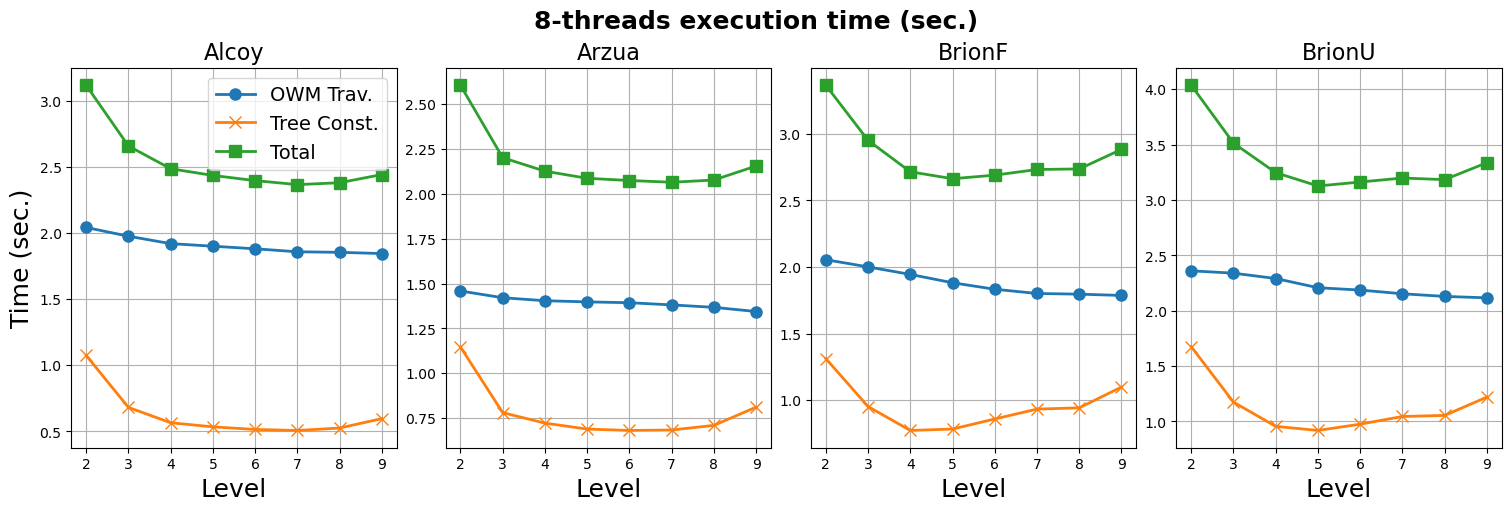

In [59]:
def plot_levels(nth,results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['owm'] for j in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree'] for j in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree']+results[name][j][nth]['owm'] for j in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Level', fontsize=xlabelfs)
        axs[i].set_xticks(x,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    if(nth==1):
        fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    if(nth==8):
        fig.suptitle('8-threads execution time (sec.)',  fontweight='bold', fontsize=18)

    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    pp = PdfPages("Optim2_8coresExecTime.pdf")
    pp.savefig(fig)
    pp.close()

plot_levels(8,res4)


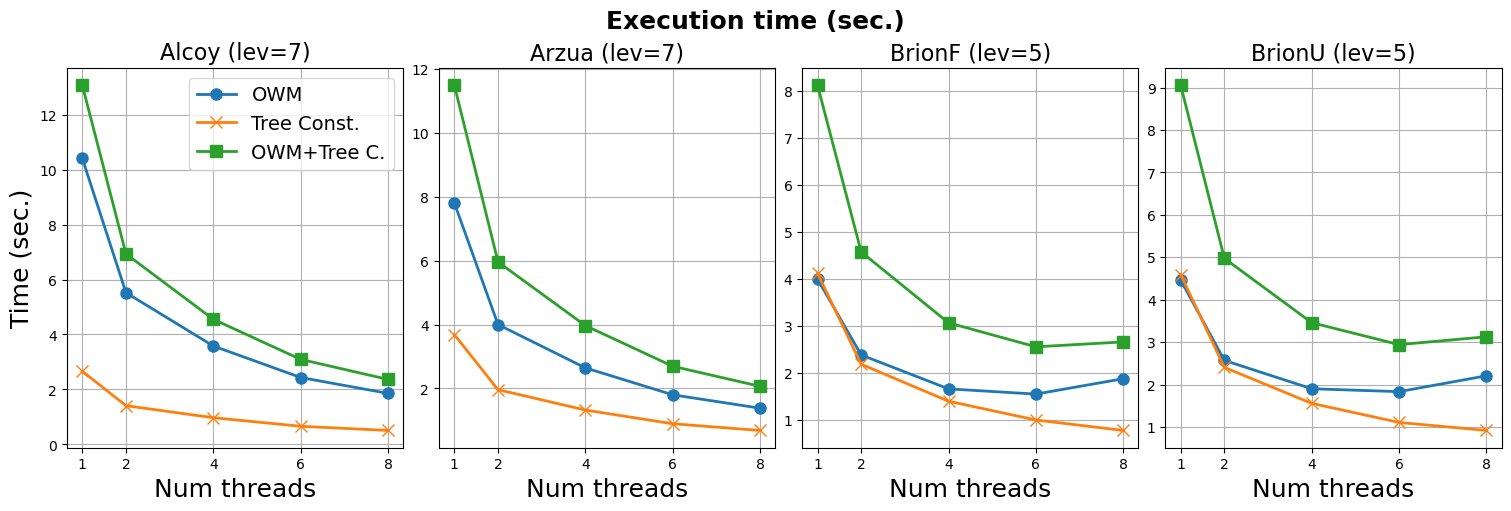

In [16]:
def plot_times_index(results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        bestlevel=min(results[name], key=lambda x: results[name][x][8]['total'])
        x=list(results[name][bestlevel].keys())
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['total'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name+ " (lev="+str(bestlevel)+")",fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_times_index(res4)

# Compare OWM traversal improvement

In [57]:
def printowm(nth,res):#best level
    for i in res:
        bestlevel=min(res[i], key=lambda x: res[i][x][nth]['total'])
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP OWM-o1 quadtree time = {:.2f}.".format(i,nth, res1[i][nth]['owm']))    
        print("Cloud {} has {}-cores OWM-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['owm'], res1[i][nth]['owm']/res[i][bestlevel][nth]['owm'] ))    

#printowm(1,res4)
printowm(8,res4)

Cloud Alcoy has best level = 7.
Cloud Alcoy has 8-cores OMP OWM-o1 quadtree time = 1.98.
Cloud Alcoy has 8-cores OWM-o2 partree time = 1.86. Speedup (o2 partree vs o1) = 1.07x.
Cloud Arzua has best level = 7.
Cloud Arzua has 8-cores OMP OWM-o1 quadtree time = 1.70.
Cloud Arzua has 8-cores OWM-o2 partree time = 1.38. Speedup (o2 partree vs o1) = 1.23x.
Cloud BrionF has best level = 5.
Cloud BrionF has 8-cores OMP OWM-o1 quadtree time = 3.07.
Cloud BrionF has 8-cores OWM-o2 partree time = 1.88. Speedup (o2 partree vs o1) = 1.63x.
Cloud BrionU has best level = 5.
Cloud BrionU has 8-cores OMP OWM-o1 quadtree time = 3.89.
Cloud BrionU has 8-cores OWM-o2 partree time = 2.21. Speedup (o2 partree vs o1) = 1.76x.


# Compare Tree construction improvement

In [33]:
def printtree(nth,res):#best level
    for i in res:
        bestlevel=min(res[i], key=lambda x: res[i][x][nth]['total'])
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP TreeConst-o1 quadtree time = {:.2f}.".format(i,nth, res1[i][nth]['qtree']))    
        print("Cloud {} has {}-cores TreeConst-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['qtree'], res1[i][nth]['qtree']/res[i][bestlevel][nth]['qtree'] ))    

#printtree(1,res4)
printtree(8,res4)

Cloud Alcoy has best level = 7.
Cloud Alcoy has 8-cores OMP TreeConst-o1 quadtree time = 3.17.
Cloud Alcoy has 8-cores TreeConst-o2 partree time = 0.51. Speedup (o2 partree vs o1) = 6.24x.
Cloud Arzua has best level = 7.
Cloud Arzua has 8-cores OMP TreeConst-o1 quadtree time = 3.75.
Cloud Arzua has 8-cores TreeConst-o2 partree time = 0.68. Speedup (o2 partree vs o1) = 5.48x.
Cloud BrionF has best level = 5.
Cloud BrionF has 8-cores OMP TreeConst-o1 quadtree time = 4.02.
Cloud BrionF has 8-cores TreeConst-o2 partree time = 0.78. Speedup (o2 partree vs o1) = 5.14x.
Cloud BrionU has best level = 5.
Cloud BrionU has 8-cores OMP TreeConst-o1 quadtree time = 4.52.
Cloud BrionU has 8-cores TreeConst-o2 partree time = 0.92. Speedup (o2 partree vs o1) = 4.92x.


# Compare Total (OWM traversal + Tree construction) improvement

In [49]:
def printtotal(nth,res):#best level
    for i in res:
        bestlevel=min(res[i], key=lambda x: res[i][x][nth]['total'])
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP Total time = {:.2f}.".format(i,nth, res1[i][nth]['total']))    
        print("Cloud {} has {}-cores Total time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['total'], res1[i][nth]['total']/res[i][bestlevel][nth]['total'] ))    

#printtotal(1,res4)
printtotal(8,res4)  

Cloud Alcoy has best level = 7.
Cloud Alcoy has 8-cores OMP Total time = 5.15.
Cloud Alcoy has 8-cores Total time = 2.37. Speedup (o2 partree vs o1) = 2.18x.
Cloud Arzua has best level = 7.
Cloud Arzua has 8-cores OMP Total time = 5.45.
Cloud Arzua has 8-cores Total time = 2.07. Speedup (o2 partree vs o1) = 2.64x.
Cloud BrionF has best level = 5.
Cloud BrionF has 8-cores OMP Total time = 7.09.
Cloud BrionF has 8-cores Total time = 2.66. Speedup (o2 partree vs o1) = 2.66x.
Cloud BrionU has best level = 5.
Cloud BrionU has 8-cores OMP Total time = 8.41.
Cloud BrionU has 8-cores Total time = 3.13. Speedup (o2 partree vs o1) = 2.69x.


# Plot Optimization 1 Quadtree execution time (for reference)

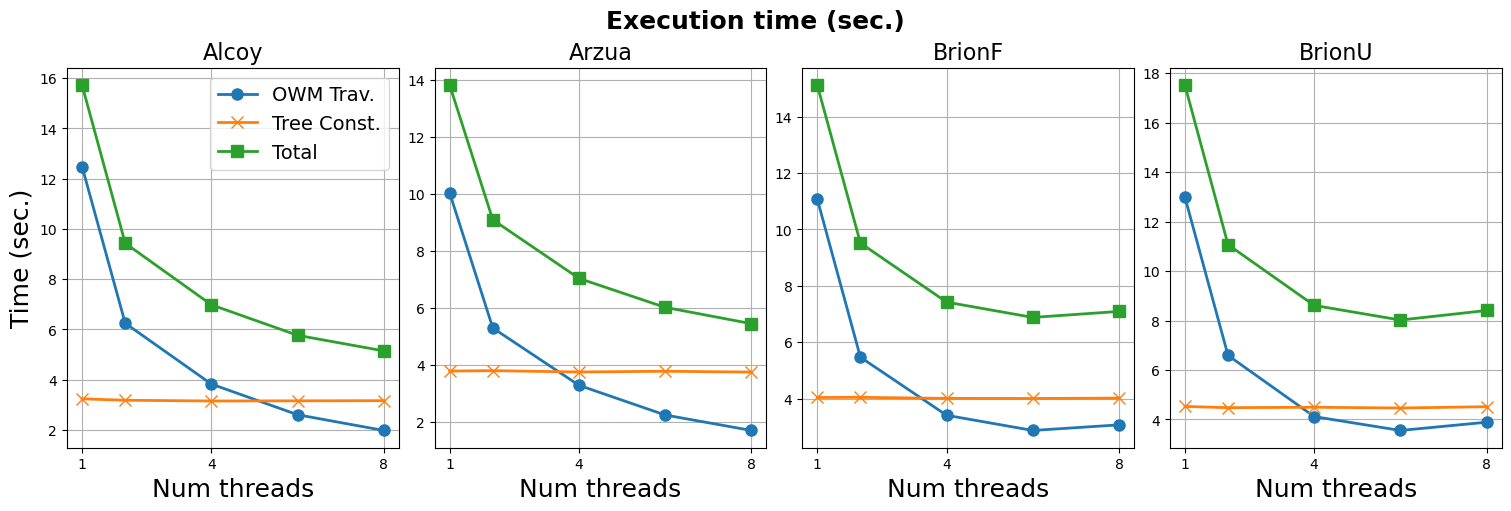

In [39]:
def plot_alltimes(results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree']+results[name][nth]['owm'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x[::2],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res1)


Phase: qtree speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.88879688 2.73956609 4.034044   5.24472694]
[1.         1.87900403 2.78388052 4.12174004 5.38811171]
[1.         1.88167963 2.93570941 4.10136695 5.26789982]
[1.         1.90946865 2.94838121 4.14406031 4.99787471]
Phase: owm speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.88481205 2.90595016 4.27440336 5.60236135]
[1.         1.95269033 2.95323735 4.33638763 5.65269836]
[1.         1.67518946 2.39993168 2.57097919 2.12451822]
[1.         1.73627711 2.34600869 2.43343431 2.02101886]
Phase: total speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.88562236 2.87044028 4.22314937 5.52561325]
[1.         1.92844646 2.89674397 4.26518136 5.56509133]
[1.         1.7739933  2.64492429 3.17163247 3.04743394]
[1.         1.82000299 2.61721126 3.0778197  2.89584359]


<Figure size 640x480 with 0 Axes>

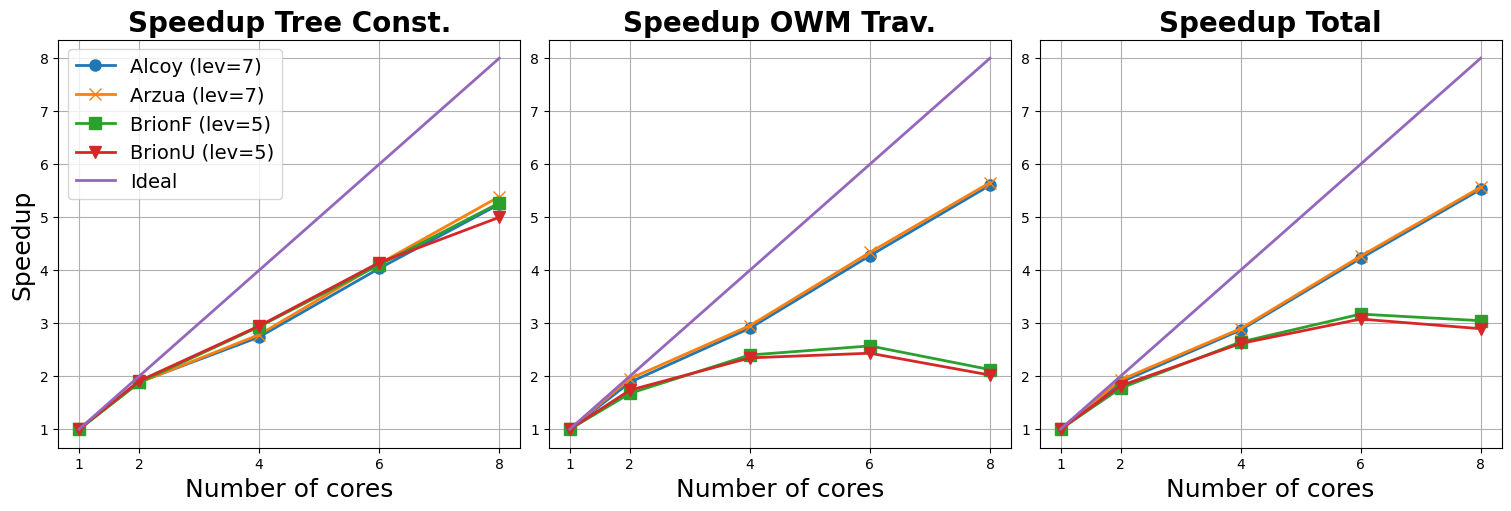

In [58]:
#Configuration variables
def plot_res(res):
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8

    fig = plt.figure()

    marks=['o-','x-','s-','v-','+-']
    bestlevel=[min(res[i], key=lambda x: res[i][x][8]['total']) for i in res]
    numthreads=list(res['Alcoy'][bestlevel[0]].keys())
    labels=['Tree Const.','OWM Trav.','Total']

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15, 5), constrained_layout=True)
    sizes=[i+" (lev="+str(j)+")" for i,j in zip(res,bestlevel)]
    sizes.append('Ideal')

    for phase,subfig in zip(['qtree','owm','total'],range(3)):
        print("Phase: "+phase+ " speedup for each cloud and best level for each cloud: "+str(list(res.keys())))
        for (i,z,lev) in zip(res,marks,bestlevel):
            print(np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in numthreads]))
            axs[subfig].plot(np.array(numthreads), np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in numthreads]), z, linewidth=linew, markersize=markers)
        axs[subfig].plot(np.array(numthreads), np.array(numthreads), '-', linewidth=linew, markersize=markers)
        axs[subfig].set_title('Speedup '+labels[subfig],  fontweight='bold', fontsize=titlefs)
        axs[subfig].set_xlabel('Number of cores', fontsize=xlabelfs)
        axs[subfig].set_xticks(numthreads,fontsize=xticksfs)
        axs[subfig].grid()

    axs[0].set_ylabel('Speedup', fontsize=ylabelfs)
    axs[0].legend(sizes,loc='best', fontsize= legendfs)
#    plt.yticks(fontsize=yticksfs)

    plt.show()

plot_res(res4)

In [49]:
pp = PdfPages("Speedup-partree.pdf")
pp.savefig(fig)
pp.close()